In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from src import cct  # Importing the cct module
import torch
from train import validate  # Importing the validate function from train.py
from timm.data import create_dataset, create_loader
from timm.utils import *
results_final_path = "result_final"

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'

def construct_model_dict(results_final_path):
    model_dict = {}

    for model_folder in os.listdir(results_final_path):
        model_path = os.path.join(results_final_path, model_folder)
        args_file = os.path.join(model_path, "args.yaml")

        if os.path.isdir(model_path) and os.path.exists(args_file):
            with open(args_file, "r") as file:
                args = yaml.safe_load(file)
                model_name = args.get("model", None)
                if model_name:
                    # Map the model_name to the initialization function
                    model_init_function = getattr(cct, model_name, None)
                    if model_init_function:
                        # Initialize the model
                        model = model_init_function(
                            pretrained=False,
                            progress=False,
                            img_size=args.get("img_size", 32),
                            positional_embedding="learnable",
                            num_classes=args.get("num_classes", 10),
                        )
                        model_dict[model_folder] = model
                        print(
                            f"Model mapped successfully: {model_folder} -> {model_name}"
                        )
                    else:
                        print(
                            f"Could not map model for folder '{model_folder}': No initialization function for '{model_name}'"
                        )
                else:
                    print(
                        f"Model name not found in args.yaml for folder '{model_folder}'"
                    )

    return model_dict

def chooseModel(modelDict):
    availableActions = {str(i + 1): k for (i, k) in enumerate(modelDict.keys())}
    nl = "\n"
    availableActionsList = [(key, val) for key, val in availableActions.items()]
    print(f"Use number keys to choose one of the models below: \n")
    print(
        f"Available Models: {nl.join(f'[{tup[0]}: {tup[1]}]' for tup in availableActionsList)}"
    )

    while True:
        userInput = input("Enter your action: ")
        if userInput not in availableActions:
            print(f"{userInput} is an invalid action. Please try again.")
        else:
            return availableActions[userInput]


modelDict = construct_model_dict(results_final_path)
model_name = chooseModel(modelDict)
model = modelDict.get(model_name, None)
# device = "cpu" 

checkpoint_path = os.path.join(results_final_path, model_name, "model_best.pth.tar")
print(f"Loading checkpoint from {checkpoint_path}")


# Load model and move to device
checkpoint = torch.load(checkpoint_path, map_location=device)
if "state_dict" in checkpoint:
    model.load_state_dict(checkpoint["state_dict"])
else:
    model.load_state_dict(checkpoint)




c:\Users\Admin\anaconda3\envs\cv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model mapped successfully: Bryan_full_cct_6_3x1_32 -> cct_6_3x1_32
Model mapped successfully: Bryan_full_cct_7_3x1_32_c100 -> cct_7_3x1_32_c100
Model mapped successfully: Bryan_full_cct_7_3x1_32_c100_DynEmbed -> cct_DynEmbed_7_3x1_32
Model mapped successfully: Bryan_full_cct_7_3x1_32_DynEmbed_TempScaleAttn -> cct_DynEmbedTempScaleAttn_7_3x1_32
Model mapped successfully: full_cct_7_3x1_32 -> cct_7_3x1_32
Use number keys to choose one of the models below: 

Available Models: [1: Bryan_full_cct_6_3x1_32]
[2: Bryan_full_cct_7_3x1_32_c100]
[3: Bryan_full_cct_7_3x1_32_c100_DynEmbed]
[4: Bryan_full_cct_7_3x1_32_DynEmbed_TempScaleAttn]
[5: full_cct_7_3x1_32]
Loading checkpoint from result_final\Bryan_full_cct_7_3x1_32_c100\model_best.pth.tar


In [2]:
print(model_name)

Bryan_full_cct_7_3x1_32_c100


In [3]:
class ModifiedCCT(cct.CCT):
    def __init__(self, *args, **kwargs):
        super(ModifiedCCT, self).__init__(*args, **kwargs)
        self.return_attention_maps = False  # Add a flag to control attention map extraction

    def forward(self, x):
        x = self.tokenizer(x)
        attention_maps = []
        for blk in self.classifier.blocks:
            x, attn_map = blk(x, return_attention_map=True)  # Assume blk returns both output and attention map
            attention_maps.append(attn_map)
        return self.classifier(x), attention_maps

In [4]:
class Modifieddynembed(cct.CCT_custom_DynEmbed):
    def __init__(self, *args, **kwargs):
        super(Modifieddynembed, self).__init__(*args, **kwargs)
        self.return_attention_maps = False  # Add a flag to control attention map extraction

    def forward(self, x):
        x = self.tokenizer(x)
        attention_maps = []
        for blk in self.classifier.blocks:
            x, attn_map = blk(x, return_attention_map=True)  # Assume blk returns both output and attention map
            attention_maps.append(attn_map)
        return self.classifier(x), attention_maps

In [5]:
class Modifieddynembedtempscaleattn(cct.CCT_custom_DynEmbedTempScaleAttn):
    def __init__(self, *args, **kwargs):
        super(Modifieddynembedtempscaleattn, self).__init__(*args, **kwargs)
        self.return_attention_maps = False  # Add a flag to control attention map extraction

    def forward(self, x):
        x = self.tokenizer(x)
        attention_maps = []
        for blk in self.classifier.blocks:
            x, attn_map = blk(x, return_attention_map=True)  # Assume blk returns both output and attention map
            attention_maps.append(attn_map)
        return self.classifier(x), attention_maps

In [6]:
#Bryan_full_cct_6_3x1_32
if model_name == 'Bryan_full_cct_6_3x1_32':
    modified_model = ModifiedCCT(pretrained=False, progress=False,
                    img_size=32,
                    embedding_dim=256,
                    n_input_channels=3,
                    n_conv_layers=1,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    pooling_kernel_size=3,
                    pooling_stride=2,
                    pooling_padding=1,
                    dropout=0.,
                    attention_dropout=0.1,
                    stochastic_depth=0.1,
                    num_layers=6,
                    num_heads=4,
                    mlp_ratio=2,
                    num_classes=10,
                    positional_embedding='learnable',)  # Use the same parameters as before
    modified_model.load_state_dict(model.state_dict())  # Load the state dict from the original model
    print('model loaded')
elif model_name == 'Bryan_full_cct_7_3x1_32_c100':
    #Bryan_full_cct_7_3x1_32_c100
    modified_model = ModifiedCCT(pretrained=False, progress=False,
                    img_size=32,
                    embedding_dim=256,
                    n_input_channels=3,
                    n_conv_layers=1,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    pooling_kernel_size=3,
                    pooling_stride=2,
                    pooling_padding=1,
                    dropout=0.,
                    attention_dropout=0.1,
                    stochastic_depth=0.1,
                    num_layers=7,
                    num_heads=4,
                    mlp_ratio=2,
                    num_classes=100,
                    positional_embedding='learnable',)  # Use the same parameters as before
    modified_model.load_state_dict(model.state_dict())  # Load the state dict from the original model
    print('model loaded')
elif model_name == 'Bryan_full_cct_7_3x1_32_c100_DynEmbed':
    #Bryan_full_cct_7_3x1_32_c100_DynEmbed
    modified_model = Modifieddynembed(pretrained=False, progress=False,
                    img_size=32,
                    embedding_dim=256,
                    n_input_channels=3,
                    n_conv_layers=1,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    pooling_kernel_size=3,
                    pooling_stride=2,
                    pooling_padding=1,
                    dropout=0.,
                    attention_dropout=0.1,
                    stochastic_depth=0.1,
                    num_layers=7,
                    num_heads=4,
                    mlp_ratio=2,
                    num_classes=100,
                    positional_embedding='learnable',)  # Use the same parameters as before
    modified_model.load_state_dict(model.state_dict())  # Load the state dict from the original model
    print('model loaded')
elif model_name == 'Bryan_full_cct_7_3x1_32_DynEmbed_TempScaleAttn':
    #Bryan_full_cct_7_3x1_32_DynEmbed_TempScaleAttn
    modified_model= Modifieddynembedtempscaleattn(pretrained=False, progress=False,
                    img_size=32,
                    embedding_dim=256,
                    n_input_channels=3,
                    n_conv_layers=1,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    pooling_kernel_size=3,
                    pooling_stride=2,
                    pooling_padding=1,
                    dropout=0.,
                    attention_dropout=0.1,
                    stochastic_depth=0.1,
                    num_layers=7,
                    num_heads=4,
                    mlp_ratio=2,
                    num_classes=10,
                    positional_embedding='learnable',)  # Use the same parameters as before
    modified_model.load_state_dict(model.state_dict())  # Load the state dict from the original model
    print('model loaded')
else:
    print('non compatible model')


model loaded


<built-in method type of Tensor object at 0x00000261CCB114E0>


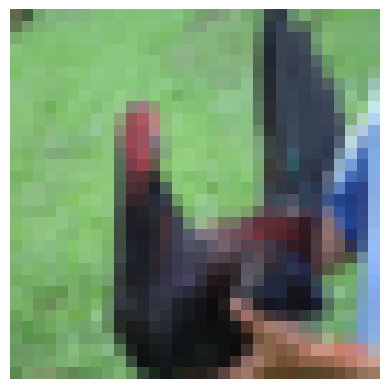

In [8]:
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt



preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# input_image = Image.open('./data/cifar100/val/apple/113.png')
input_image = Image.open('./data/cifar10/val/bird/25.png')
input_tensor = preprocess(input_image)
print(input_tensor.type)
input_data = input_tensor.unsqueeze(0)


plt.imshow(input_image)
plt.axis('off') 
plt.show()

In [ ]:
modified_model.to(device)
input_data = input_data.to(device)
modified_model.eval()
print("Model loaded successfully.")
# print(device)

Model loaded successfully.


In [ ]:
output, attention_maps = modified_model(input_data)

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


In [ ]:
def process_attention_maps(attention_maps, img_size):
    processed_maps = []
    for attn in attention_maps:
        # Normalize the attention map
        attn = (attn - attn.min()) / (attn.max() - attn.min())

        # Reshape the attention map from 1D to 2D if necessary
        # Assuming the attention map is square for simplicity
        side_length = int(attn.size(-1) ** 0.5)
        attn_reshaped = attn.view(-1, side_length, side_length)

        # Resize to match the image size
        attn_resized = torch.nn.functional.interpolate(attn_reshaped.unsqueeze(1), size=img_size, mode='bilinear', align_corners=False)
        processed_maps.append(attn_resized.squeeze().detach().cpu().numpy())

    return processed_maps

In [ ]:
attention_maps_processed = process_attention_maps(attention_maps, input_data.shape[-2:])

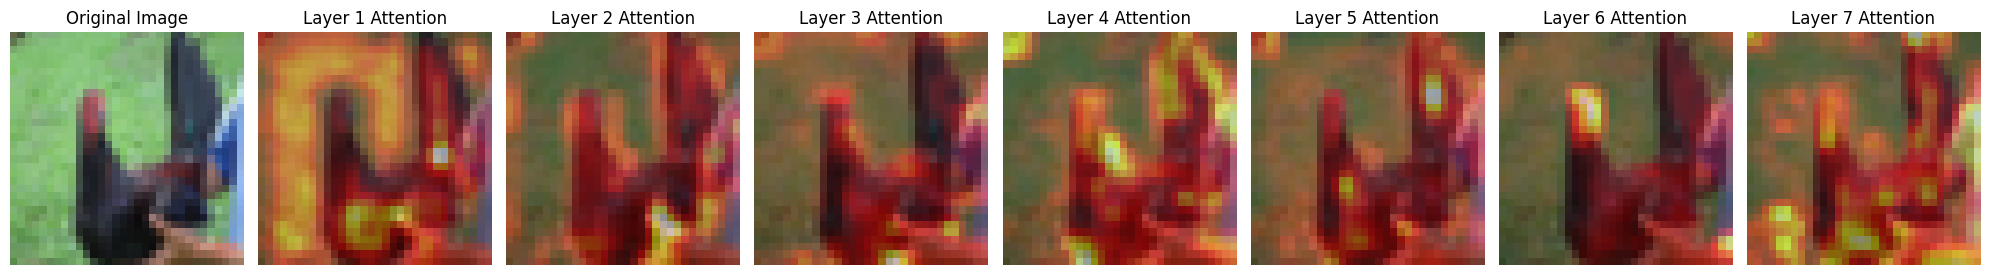

In [ ]:
from torchvision.transforms import ToPILImage
def visualize_attention(img, attention_maps):
    fig, axs = plt.subplots(1, len(attention_maps) + 1, figsize=(20, 5))

    # Show original image
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    for i, attn_map in enumerate(attention_maps):
        # Assuming each attention map is of shape [1024, 32, 32] and we average over the first dimension
        attn_map_2d = attn_map.mean(axis=0)  # Reduce to shape [32, 32]

        # Normalize the attention map for better visualization
        attn_map_normalized = (attn_map_2d - attn_map_2d.min()) / (attn_map_2d.max() - attn_map_2d.min())

        axs[i + 1].imshow(img)  # Show the image
        axs[i + 1].imshow(attn_map_normalized, cmap='hot', alpha = 0.5 )  # Overlay the attention map
        axs[i + 1].axis('off')
        axs[i + 1].set_title(f'Layer {i + 1} Attention')

    plt.tight_layout()
    plt.show()

# Convert your input_data tensor to an image
# Assuming input_data is a normalized tensor, you need to denormalize it
img = input_image

# Visualize

visualize_attention(img, attention_maps_processed)

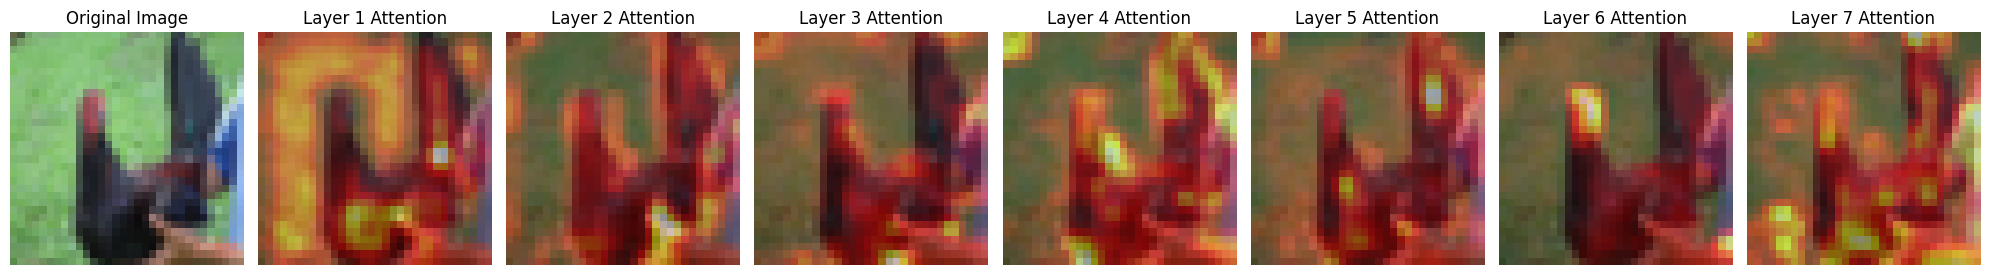

In [ ]:
to_pil = ToPILImage()
img = input_image

# Visualize
visualize_attention(img, attention_maps_processed)